### Imports

In [11]:
# !pip install tqdm
# !pip install gymnasium
# !pip install gym_anytrading
# !pip install stable_baselines3



from tqdm import tqdm
import random
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch

### Create Env

In [12]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
trade_fee = 0.05 # <--- + - 0.05
window_size = 10
start_index = 300
# end_index = len(df)
end_index = 2000

env_name = 'forex-v0' # 'stocks-v0'  # or 'forex-v0'
env = gym.make(env_name, df = df, window_size=10, frame_bound=(start_index, end_index))
env.trade_fee = trade_fee

### Define Functions

In [13]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# Integrated Callback for Progress Bar and Saving the model and environment periodically
class ProgressAndSaveCallback(BaseCallback):
    def __init__(self, check_freq: int, save_freq: int, model_filename: str, env_filename: str, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.save_freq = save_freq
        self.model_filename = model_filename
        self.env_filename = env_filename
        self.progress_bar = None

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        # Update the progress bar
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)

        # Save the model and environment periodically
        if self.n_calls % self.save_freq == 0:
            model_filename = self.model_filename + str(self.n_calls) 
            env_filename = self.env_filename + str(self.n_calls) 

            self.model.save(model_filename)
            with open(env_filename, 'wb') as fi:
                pickle.dump(self.model.get_env(), fi)
            if self.verbose > 0:
                print(f"\nSaved model and environment at step {self.num_timesteps}")

        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        # File paths
        realmodel_filename = 'NNmodels_envs/model_' + type(model).__qualname__ + '_' + str(seed) + '_' + str(total_learning_timesteps)
        realenv_filename = 'NNmodels_envs/env_' + type(model).__qualname__ + '_' + str(seed) + '_' + str(total_learning_timesteps)

        model_filename = 'NNmodels_envs/model_' + type(model).__qualname__ + '_' + str(seed) + '_' 
        env_filename = 'NNmodels_envs/env_' + type(model).__qualname__ + '_' + str(seed) + '_' 

        # print(f'model {type(model)}')
        # print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # Check if the model file exists
        if not os.path.exists(realmodel_filename + '.zip'):
            # Train the model if it doesn't exist
            print(f"Training the model as {model_filename}.zip does not exist.")
            # Define the callback with a check frequency of 10,000 steps and save frequency of 50,000 steps
            integrated_callback = ProgressAndSaveCallback(
                check_freq=10000,  # Update the progress bar every 10,000 steps
                save_freq=10000,   # Save the model and environment every 50,000 steps
                model_filename=model_filename,
                env_filename=env_filename,
                verbose=0
            )
            # Train the model with the callback
            model.learn(total_timesteps=total_learning_timesteps, callback=integrated_callback)
            print(f'model.learn() done')
        else:
            # Model file exists
            print(f"Model {realmodel_filename}.zip already exists. Skipping training.")
            # Load the model
            model = model.load(realmodel_filename)
            # Load the environment using pickle
            with open(realenv_filename, 'rb') as fi:
                t_vec_env = pickle.load(fi)
            # Set the loaded environment to the model
            model.set_env(t_vec_env)
    
        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

### Train + Test Env

In [14]:
seed = 42  # random seed
total_num_episodes = 40

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, 4)]} # 3+1

learning_timesteps_list_in_K = [10, 20, 30, 40, 50]  # in K

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [DQN, A2C, PPO]


for model_class in model_class_list:
    policy_dict = model_class.policy_aliases
    # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
    # MlpPolicy or MlpLstmPolicy
    policy = policy_dict.get('MlpPolicy')
    if policy is None:
        policy = policy_dict.get('MlpLstmPolicy')

    for timesteps in learning_timesteps_list_in_K:
        total_learning_timesteps = timesteps * 1000
        step_key = f'{timesteps}K'

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            # plot_data[plot_key] = rewards
            plot_data[plot_key] = [min, avg, max]
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : forex-v0
seed                     : 42
--------------------------------------------------------------------------------
Model NNmodels_envs/model_DQN_42_10000.zip already exists. Skipping training.


  0%|          | 0/40 [00:00<?, ?it/s]

Episode: 30, Avg. Reward: 1866600.250: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Min. Reward          : -1158395.375
Avg. Reward          : 1835289.750
Max. Reward          : 4574408.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_DQN_42_20000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -2757845.000: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Min. Reward          : -6478964.000
Avg. Reward          : -2772342.000
Max. Reward          : 376373.531
--------------------------------------------------------------------------------
Model NNmodels_envs/model_DQN_42_30000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -4247275.500: 100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Min. Reward          : -7011449.000
Avg. Reward          : -4270063.500
Max. Reward          : -2395200.500
--------------------------------------------------------------------------------
Model NNmodels_envs/model_DQN_42_40000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: 1178503.875: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Min. Reward          : -285232.531
Avg. Reward          : 1149056.375
Max. Reward          : 2723120.750
--------------------------------------------------------------------------------
Model NNmodels_envs/model_DQN_42_50000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -2290382.750: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


Min. Reward          : -4282067.000
Avg. Reward          : -2256574.000
Max. Reward          :   3340.344
--------------------------------------------------------------------------------
Model NNmodels_envs/model_A2C_42_10000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -1245877.125: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


Min. Reward          : -6078124.000
Avg. Reward          : -1186536.750
Max. Reward          :      0.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_A2C_42_20000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -298776.438: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Min. Reward          : -3113123.250
Avg. Reward          : -231551.750
Max. Reward          :      0.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_A2C_42_30000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -298776.438: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


Min. Reward          : -3113123.250
Avg. Reward          : -231551.750
Max. Reward          :      0.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_A2C_42_40000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -298776.438: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Min. Reward          : -3113123.250
Avg. Reward          : -231551.750
Max. Reward          :      0.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_A2C_42_50000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -200443.438: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Min. Reward          : -3113123.250
Avg. Reward          : -155343.656
Max. Reward          :      0.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_PPO_42_10000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: -442147.375: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Min. Reward          : -7965879.500
Avg. Reward          : -875783.312
Max. Reward          : 6202090.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_PPO_42_20000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: 639481.375: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


Min. Reward          : -8635782.000
Avg. Reward          :  58127.836
Max. Reward          : 6758454.500
--------------------------------------------------------------------------------
Model NNmodels_envs/model_PPO_42_30000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: 2234689.500: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]


Min. Reward          : -4858382.500
Avg. Reward          : 1758690.750
Max. Reward          : 9168412.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_PPO_42_40000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: 2517128.000: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Min. Reward          : -5103167.500
Avg. Reward          : 1997963.625
Max. Reward          : 8824437.000
--------------------------------------------------------------------------------
Model NNmodels_envs/model_PPO_42_50000.zip already exists. Skipping training.


Episode: 30, Avg. Reward: 2592966.000: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]

Min. Reward          : -4921966.500
Avg. Reward          : 2069347.750
Max. Reward          : 8824437.000


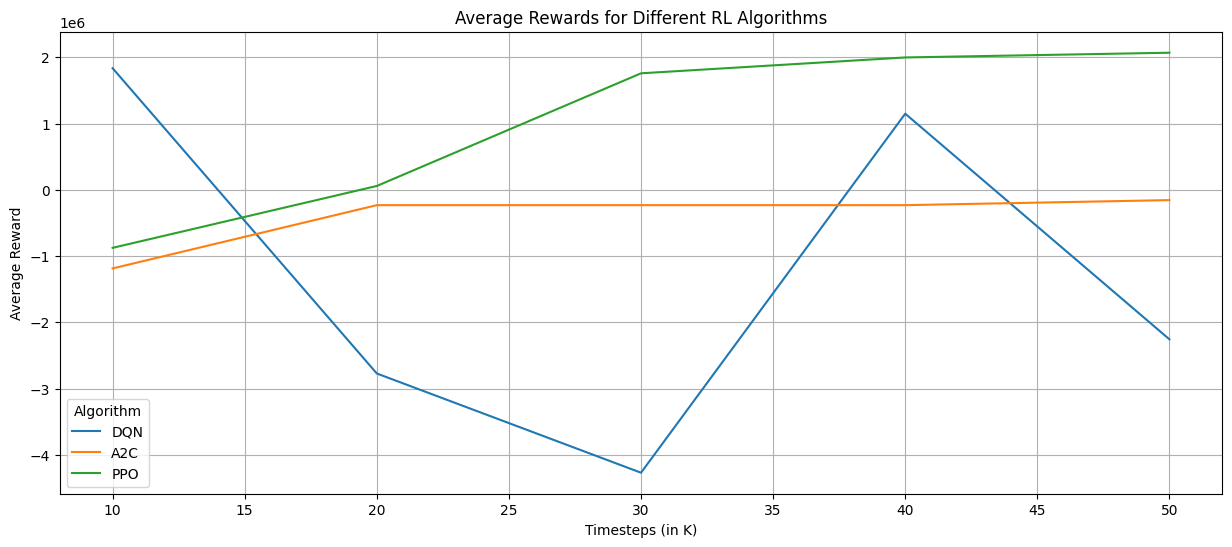

In [15]:
# print(plot_data)
# data = pd.DataFrame(plot_data)
# print (data)
# data.plot(kind="line", figsize=(15, 6))

# Assuming plot_data is already populated
# Create a new dictionary to store only the average values
avg_plot_data = {'x': learning_timesteps_list_in_K}  # Using timesteps as x-axis

# Extracting the average values
for model_class in model_class_list:
    class_name = model_class.__name__
    avg_values = []
    for timesteps in learning_timesteps_list_in_K:
        step_key = f'{timesteps}K'
        plot_key = f'{class_name}_rewards_{step_key}'
        if plot_key in plot_data:
            min_val, avg_val, max_val = plot_data[plot_key]
            avg_values.append(avg_val)
    
    # Store the average values in the new dictionary
    avg_plot_data[class_name] = avg_values

# Convert to DataFrame
avg_data = pd.DataFrame(avg_plot_data)

# Set the x-axis as the first column (timesteps)
avg_data.set_index('x', inplace=True)

# Plot the data
avg_data.plot(kind="line", figsize=(15, 6))
plt.xlabel('Timesteps (in K)')
plt.ylabel('Average Reward')
plt.title('Average Rewards for Different RL Algorithms')
plt.legend(title='Algorithm')
plt.grid(True)
plt.show()

### Plot Results

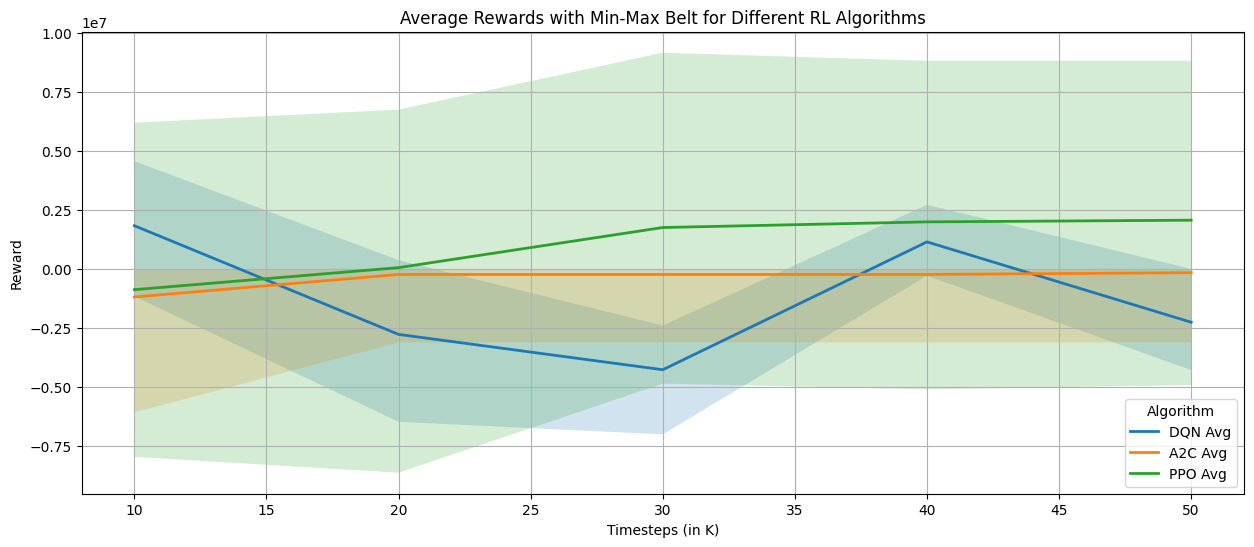

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming plot_data is already populated
# Create a new dictionary to store the min, avg, and max values
avg_plot_data = {'x': learning_timesteps_list_in_K}  # Using timesteps as x-axis
min_plot_data = {'x': learning_timesteps_list_in_K}
max_plot_data = {'x': learning_timesteps_list_in_K}

# Extracting the min, avg, and max values
for model_class in model_class_list:
    class_name = model_class.__name__
    avg_values = []
    min_values = []
    max_values = []
    for timesteps in learning_timesteps_list_in_K:
        step_key = f'{timesteps}K'
        plot_key = f'{class_name}_rewards_{step_key}'
        if plot_key in plot_data:
            min_val, avg_val, max_val = plot_data[plot_key]
            min_values.append(min_val)
            avg_values.append(avg_val)
            max_values.append(max_val)
    
    # Store the min, avg, and max values in the dictionaries
    avg_plot_data[class_name] = avg_values
    min_plot_data[class_name] = min_values
    max_plot_data[class_name] = max_values

# Convert to DataFrame
avg_data = pd.DataFrame(avg_plot_data)
min_data = pd.DataFrame(min_plot_data)
max_data = pd.DataFrame(max_plot_data)

# Set the x-axis as the first column (timesteps)
avg_data.set_index('x', inplace=True)
min_data.set_index('x', inplace=True)
max_data.set_index('x', inplace=True)

# Plot the data
plt.figure(figsize=(15, 6))

# Plotting each algorithm line with a belt for min-max range
for model_class in model_class_list:
    class_name_str = model_class.__name__

    # Convert the relevant data to numpy arrays
    x_vals = avg_data.index.values
    avg_vals = avg_data[class_name_str].values
    min_vals = min_data[class_name_str].values
    max_vals = max_data[class_name_str].values

    plt.plot(x_vals, avg_vals, label=f'{class_name_str} Avg', linewidth=2)

    # Fill between the min and max values for the belt effect
    plt.fill_between(
        x_vals,
        min_vals,
        max_vals,
        alpha=0.2  # Adjust the alpha for transparency
    )

plt.xlabel('Timesteps (in K)')
plt.ylabel('Reward')
plt.title('Average Rewards with Min-Max Belt for Different RL Algorithms')
plt.legend(title='Algorithm')
plt.grid(True)
plt.show()